In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import pytry

In [23]:
import timeit

class FileProbeProcess(nengo.Process):
    def __init__(self, filename, buffer_time=1.0, buffer_steps=100, dtype=np.dtype(float)):
        self.filename = filename
        self.buffer_time = buffer_time
        self.buffer_steps = buffer_steps
        self.f = None
        self.dtype = dtype
        super(FileProbeProcess, self).__init__(default_size_out=0)
        
    def flush(self):
        for i in range(self.n_steps):
            self.data[i].tofile(self.f)
        self.f.flush()
        self.n_steps = 0
        self.last_time = timeit.default_timer()
    
        
    def make_step(self, shape_in, shape_out, dt, rng):
        if self.f is None:
            self.f = open(self.filename, 'wb')

            self.n_steps = 0
            self.last_time = timeit.default_timer()
            self.data = np.zeros((self.buffer_steps, shape_in[0]), dtype=self.dtype)
        
        
        def step(t, x):
            self.data[self.n_steps] = x
            self.n_steps += 1
            if self.n_steps >= self.buffer_steps or timeit.default_timer() > self.last_time + self.buffer_time:
                self.flush()
                
        return step
        
        
    def close(self):
        self.flush()
        self.f.close()
        self.f = None
        
        

In [3]:
data = pd.read_csv("pinsoro-2017-06-20-145454904791-small.csv", low_memory=False)

x = np.array(data.iloc[:,11:195]).astype(float) #array of data for purple child (points in space for each frame)
labs = np.array(data.iloc[:,218]).astype(str) #array of labels (purple child annotations, engagement)
a = []
for i in range(x.shape[1]):
    y = pd.Series(x[:,i])
    z = y.interpolate(limit_direction='both')
    a.append(z)
a = pd.DataFrame(a)
a = a.dropna()
a = np.array(a).T

dt = 0.001

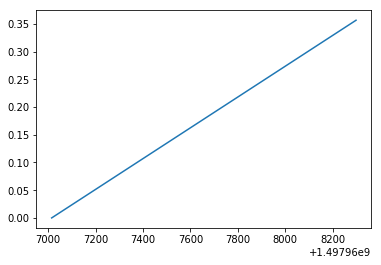

In [46]:
data_t = np.array(data['timestamp'])


plt.plot(data_t, (data_t-data_t[0])/60/60)

In [4]:
def extract_pattern(start, end): #function to extract consecutive frames with the same label 
    pattern = np.array(a[start:end,:]).astype(float)
    frames = np.array(data.iloc[start:end,9]).astype(int)

    good_indices = frames != -1
    frames = frames[good_indices]
    pattern = pattern[good_indices]

    fps = 30.0
    t_sample = (frames - frames[0])/fps

    t = np.arange(int(t_sample[-1]/dt))*dt

    result = []
    for i in range(pattern.shape[1]):       
        p = np.interp(t, t_sample, pattern[:,i])
        result.append(p)
    result = np.array(result).T

    return t, result

In [5]:
start=[]
start.append(0)
end=[]
label = []
for i in range(1, (len(labs)-1)):
    if labs[i]!=labs[i-1]:
        start.append(i)
    if labs[i]!=labs[i+1]:
        end.append(i)
        label.append(labs[i])

In [6]:
t_noplay=[]
p_noplay=[]
t_goal=[]
p_goal=[]
t_aim=[]
p_aim=[]

for i in range(1,(len(start)-1)):
    if label[i]==('noplay'):
        ti, pi = extract_pattern(start[i], end[i])
        t_noplay.append(ti)
        p_noplay.append(pi)
    if label[i]==('goaloriented'):
        ti, pi = extract_pattern(start[i], end[i])
        t_goal.append(ti)
        p_goal.append(pi)
    if label[i]==('aimless'):
        ti, pi = extract_pattern(start[i], end[i])
        t_aim.append(ti)
        p_aim.append(pi)

In [7]:
############ randomly split data 80/20 into training and testing sets ############ 
random.shuffle(p_goal)
goal_train = p_goal[:(int(len(p_goal)*0.8))] 
goal_test = p_goal[(int(len(p_goal)*0.8)):]

random.shuffle(p_noplay)
noplay_train = p_noplay[:(int(len(p_noplay)*0.8))]
noplay_test = p_noplay[(int(len(p_noplay)*0.8)):]

In [8]:
############ create pca model and convert each pattern into single dimension (first PCA construct) ############ 
train_all = np.vstack(goal_train+noplay_train)
pca_model = PCA(n_components=2).fit(train_all)

goal_patterns1 = {}
goal_patterns2 = {}
i=0
for gp in goal_train:
    goal_patterns1[i] = pca_model.transform(gp)[:,0]
    goal_patterns2[i] = pca_model.transform(gp)[:,1]
    i+=1

noplay_patterns1 = {}
noplay_patterns2 = {}
i=0
for npp in noplay_train:
    noplay_patterns1[i] = pca_model.transform(npp)[:,0]
    noplay_patterns2[i] = pca_model.transform(npp)[:,1]
    i+=1

In [9]:
goal_patterns1 = [(goal_patterns1[key]) for key in goal_patterns1.keys()]
goal_patterns2 = [(goal_patterns2[key]) for key in goal_patterns2.keys()]
noplay_patterns1 = [(noplay_patterns1[key]) for key in noplay_patterns1.keys()]
noplay_patterns2 = [(noplay_patterns2[key]) for key in noplay_patterns2.keys()]

goal_patterns = np.vstack([goal_patterns1[0], goal_patterns2[0]]).T
for gp in range(1,len(goal_train)):
    goal_patterns = np.append(goal_patterns, (np.vstack([goal_patterns1[gp], goal_patterns2[gp]]).T), axis=0) 
noplay_patterns = np.vstack([noplay_patterns1[0], noplay_patterns2[0]]).T
for npp in range(1,len(noplay_train)):
    noplay_patterns = np.append(noplay_patterns, (np.vstack([noplay_patterns1[npp], noplay_patterns2[npp]]).T), axis=0) 

In [85]:
############ TRAINING WITH 80% ############ 
D = 2

theta = 0.5
net = nengo.Network()
with net:
    process = nengo.processes.WhiteSignal(period=100., high=3.0, y0=0)
    #rw = nengolib.networks.RollingWindow(theta=theta, n_neurons=q.n_neurons, process=process, neuron_type=nengo.LIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=1))
    rw = []
    for i in range(D):
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.LIFRate()))

c:\users\terry\py3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [65]:
s_window = int(theta/dt)
s_pattern = len(min(goal_patterns1, key=len))

t_window = np.linspace(0, 1, s_window)
inv_basis = rw[0].inverse_basis(t_window)


n_keep = 10*1000

eval_points=[]
target = []
for i in range(s_pattern)[:n_keep]:
    eval_points.append(np.dot(inv_basis, np.roll(goal_patterns, i)[:s_window]).T)
    target.append([1])
for i in range(s_pattern)[:n_keep]:  
    eval_points.append(np.dot(inv_basis, np.roll(noplay_patterns, i)[:s_window]).T)
    target.append([-1])
eval_points = np.array(eval_points).reshape(len(eval_points), -1)

In [86]:
############ TEST ON TRAINING PATTERNS ############ 

with net:

    pool = nengo.Ensemble(n_neurons=3000, dimensions=eval_points.shape[1],
                          neuron_type=nengo.LIFRate(), seed=1)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out

    result = nengo.Node(None, size_in=1)
    dec_conn = nengo.Connection(pool, result,
                     eval_points=eval_points, scale_eval_points=False,
                     function=target, synapse=0.1)

In [82]:
train_all1 = np.array(goal_patterns1[0])
for gp in range(1,(len(goal_patterns1))):
    train_all1 = np.hstack([train_all1,goal_patterns1[gp]])
train_all1 = train_all1[:n_keep]
for npp in range(0,(len(noplay_patterns1))):
    train_all1 = np.hstack([train_all1,noplay_patterns1[npp]])
train_all1 = train_all1[:n_keep*2]

train_all2 = np.array(goal_patterns2[0])
for gp in range(1,(len(goal_patterns2))):
    train_all2 = np.hstack([train_all2,goal_patterns2[gp]])
train_all2 = train_all2[:n_keep]
for npp in range(0,(len(noplay_patterns2))):
    train_all2 = np.hstack([train_all2,noplay_patterns2[npp]])
train_all2 = train_all2[:n_keep*2]


In [83]:
train_all = np.vstack([train_all1, train_all2]).T

In [87]:



presentation_time_train=0.001


model = nengo.Network()
model.networks.append(net)
with model:    
    stim = nengo.Node(nengo.processes.PresentInput(train_all, presentation_time=presentation_time_train))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    #fp_result = nengo.Node(FileProbeProcess('result.data'), size_in=result.size_out)
    #nengo.Connection(result, fp_result, synapse=None)
    p_result = nengo.Probe(result)
    
    #fp_stim = nengo.Node(FileProbeProcess('stim.data'), size_in=stim.size_out)
    #nengo.Connection(stim, fp_stim, synapse=None)
    p_stim = nengo.Probe(stim)
    
    #fp_pool = nengo.Node(FileProbeProcess('pool.data'), size_in=pool.size_out)
    #nengo.Connection(pool, fp_pool, synapse=None)
    p_pool = nengo.Probe(pool)
sim = nengo.Simulator(model)
sim.run(20)
#fp_result.output.close()
#fp_stim.output.close()
#fp_pool.output.close()

c:\users\terry\documents\github\nengolib\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

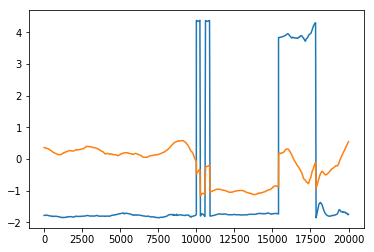

In [88]:
plt.plot(train_all[:,:])

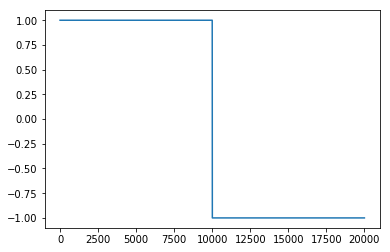

In [89]:
plt.plot(target)

In [90]:
train_all1.shape

(20000,)

In [91]:
#data_result = np.fromfile('result.data').reshape(-1, result.size_out)
#data_stim = np.fromfile('stim.data').reshape(-1, stim.size_out)
#data_pool = np.fromfile('pool.data').reshape(-1, pool.size_out)



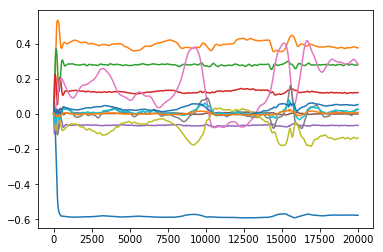

In [92]:
plt.plot(data_pool)

In [ ]:
############ GET RESULTS ############ 

goal_train_len = {}
goal_train_len[0] = int(len(goal_patterns1[0])*presentation_time_train/dt)
for i in range(1,len(goal_train)):
    goal_train_len[i] = goal_train_len[i-1]+int(len(goal_patterns1[i])*presentation_time_train/dt)

goal_train_means = {}
goal_train_means[0] = np.mean(sim.data[p_result][0:goal_train_len[0]])
for i in range(1,len(goal_train)):
    goal_train_means[i] = np.mean(sim.data[p_result][goal_train_len[i-1]:goal_train_len[i]])

noplay_train_len = {}
noplay_train_len[0] = int(len(noplay_patterns1[0])*presentation_time_train/dt)
for i in range(1,len(noplay_train)):
    noplay_train_len[i] = noplay_train_len[i-1]+int(len(noplay_patterns1[i])*presentation_time_train/dt)

noplay_train_means = {}
noplay_train_means[0] = np.mean(sim.data[p_result][goal_train_len[len(goal_train_len)-1]:noplay_train_len[0]+goal_train_len[len(goal_train_len)-1]])
for i in range(1,len(noplay_train)):
    noplay_train_means[i] = np.mean(sim.data[p_result][noplay_train_len[i-1]:noplay_train_len[i]])

for j in range(len(goal_patterns1)):
    key_j = 'gtr_{}'.format(j)  
    goal_train_means[key_j] = goal_train_means.pop(j)

for j in range(len(noplay_patterns1)):
    key_j = 'ntr_{}'.format(j)  
    noplay_train_means[key_j] = noplay_train_means.pop(j)

In [ ]:
means = {**goal_train_means, **noplay_train_means}

print(means)